# FiwMatch / UDA
## Sepi-supervised learning

Requires : 
pytorch 1.3.1
torchvision 0.4.2
numpy 1.18.1
matplotlib 3.1.3
pillow 6.2.1

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Custom packages
import augmentations
import datasets
from utils import TrainStats, test_net
from layers import WideResnetExpand, WideResnetBlock, norm_block

In [2]:
print("pytorch",torch.__version__)
print("cuda", torch.version.cuda)
print("cudnn", torch.backends.cudnn.version())
torch.cuda.is_available()


pytorch 1.3.1
cuda 10.0.130
cudnn 7605


True

Replicating the FixMatch algorithm. A wide ResNet will be trained through semi-supervised learning.


## Set-up datasets and transforms
We prepare a CIFAR 250 dataset with:
- a labeled train set with 250 labeled images (the 25 first images of each class)
- a crossvalidation set with 2000 labeled images (200 per class)
- an unlabeled train set with 47750 images, which had their label dropped

### Set-up transforms
In order to implement the FixMatch alorithm, we need to set-up a weak and a strong augmentation.

#### Weak augmentation
The weak augmentation only consists in a simple translation from a few up to 1/8th of the picture heights and width and a Cutout applied with 50% probability.

Cutout consists in erasing a 16x16 pixel area centered on a random pixels of the image. Each channel is replaced by the average across the training set so that batch statistics should not be affected by the transform.

#### Strong augmentations
The strong augmentation pipeline contains:
- Cutout
- RandAugment: random augmentation among 14 available PIL transforms (plus a 15th one, Hue shift added because why not?)


RandAugment consists in N successive application transforms sampled from the following list:


| **Operation**    | Description                                                 | Range          |
|------------------|-------------------------------------------------------------|----------------|
| **Autocontrast** | Maximizes the image contrast by setting the darkest (lightest) pixel to black (white). | |
| **Brightness**   | Adjusts the brightness of the image. B = 0 returns a black  image, B = 1 returns the original image. | B [0.05, 0.95] |
| **Color**        | Adjusts the color balance of the image like in a TV.C = 0 returns a black & white image, C = 1 returns the original image. | C [0.05, 0.95] |
| **Contrast**     | Controls the contrast of the image. A C = 0 returns a gray  image, C = 1 returns the original image. | C [0.05, 0.95] | 
| **Equalize**     | Equalizes the image histogram.                              |                |
| **Identity**     | Returns the original image.                                 |                |
| **Posterize**    | Reduces each pixel to B bits.                               | B [4, 8]       |
| **Rotate**       | Rotates the image by θ degrees.                             | θ [-30, 30]    |
| **Sharpness**    | Adjusts the sharpness of the image, where S = 0 returns a blurred image, and S = 1 returns the original image. | S [0.05, 0.95] |
| **Shear x**      | Shears the image along the horizontal axis with rate R.     | R [-0.3, 0.3]  |
| **Shear y**      | Shears the image along the vertical axis with rate R.       | R [-0.3, 0.3]  |
| **Solarize**     | Inverts all pixels above a threshold value of T.            | T [0, 1]       |
| **Translate x**  | Translates the image horizontally by (λ×image width) pixels.| λ [-0.3, 0.3]  |
| **Translate y**  | Translates the image vertically by (λ×image height) pixels. | λ [-0.3, 0.3]  |
| ***Hue shift***  | *Shifts the hue of the image (H channel in the HSV space)*  | H [-0.2, 0.2]  |

In [3]:
## Tune some RandAugment parameters
#augmentations.RandAugment.transforms["contrast"].a *=.8
#augmentations.RandAugment.transforms["brightness"].a *=.8
#augmentations.RandAugment.transforms["hue_shift"].a = .25
#augmentations.RandAugment.transforms["solarize"].a = 127
#del augmentations.RandAugment.transforms["identity"]

In [ ]:
cifar_train, cifar_test, subset_labeled, subset_crossval, subset_unlabeled = \
    datasets.get_fixmatch_datasets()


N_RAND_AUGMENT = [2]

average_color_PIL = tuple(np.uint8(rgb) for rgb in [125,122,113])

weak_augment_transform = \
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(0, translate=(1/8,1/8),
                                fillcolor=average_color_PIL),
        transforms.ToTensor()
        ])

cutout = augmentations.Cutout(
            patch_size=16,
            default_color=average_color_PIL,
            input_type="image",
            channel_drop_proba=1.0,
            inplace=True
        )

strong_augment_transform = \
    transforms.Compose([
        transforms.RandomApply([cutout],p=0.5),
        augmentations.RandAugment(N_RAND_AUGMENT),
        transforms.ToTensor()
    ])

In [4]:
cifar_train, cifar_test, subset_labeled, subset_crossval, subset_unlabeled = \
    datasets.get_fixmatch_datasets()

cifar_labeled = datasets.LabeledAugment(
        subset_labeled,
        transforms.Compose([
            transforms.RandomApply([cutout],.5),
            weak_augment_transform,
            ])
        )
cifar_crossval = datasets.LabeledAugment(
        subset_crossval,
        transforms.ToTensor())
cifar_unlabeled = datasets.UnabeledAugment(
        subset_unlabeled,
        weak_augment_transform,
        strong_augment_transform)

Files already downloaded and verified
Files already downloaded and verified


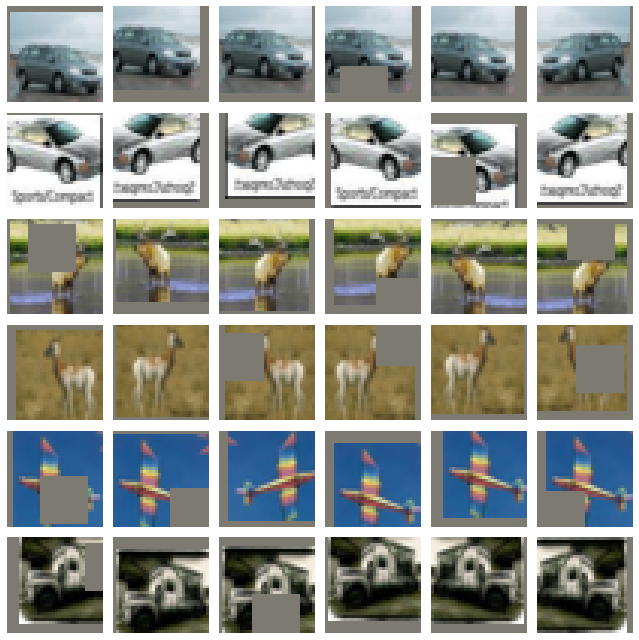

In [5]:
f, axs = plt.subplots(6,6, figsize=(9,9))
for axline in axs:
    ii = np.random.choice(250)
    for ax in axline:
        x, _ = cifar_labeled[ii]
        ax.imshow(np.moveaxis(x.numpy(),0,2))
        ax.set_axis_off()
f.tight_layout();

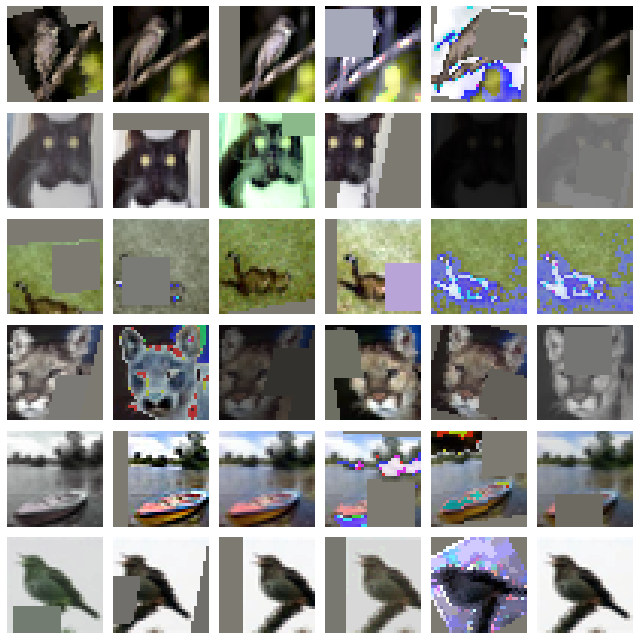

In [6]:
f, axs = plt.subplots(6,6, figsize=(9,9))
for axline in axs:
    ii = np.random.choice(47750)
    for ax in axline:
        _, img = cifar_unlabeled[ii]
        ax.imshow(np.moveaxis(img.numpy(),0,2))
        ax.set_axis_off()
f.tight_layout();

### Dataloaders
Several dataloaders are prepared:
- one labeled train loader that produces batches of weakly augmented images with their ground-truth label
- one unlabeled train loader that produces pairs of weak and strong augmentations for images
- three unaugmented dataloaders to measure loss ad accuracy on the the labeled train, cross-validation and test datasets

In [7]:
BATCH_SIZE = 64
train_loader_labeled = DataLoader(
                        dataset=cifar_labeled,
                        sampler = datasets.ContinuousSampler(
                                    len(cifar_labeled), BATCH_SIZE),
                        batch_size= BATCH_SIZE,
                        pin_memory= True,
                        num_workers = 2)
train_loader_unlabeled = DataLoader(
                        dataset=cifar_unlabeled,
                        shuffle=True,
                        batch_size= BATCH_SIZE,
                        pin_memory= True,
                        num_workers = 10)
crossval_loader = DataLoader(
                    dataset=cifar_crossval,
                    shuffle=False,
                    batch_size= BATCH_SIZE,
                    pin_memory= True,
                    num_workers = 2)
test_loader = DataLoader(cifar_test, shuffle=False, batch_size=BATCH_SIZE)

train_loader_eval = DataLoader(
                    dataset=cifar_labeled,
                    batch_size= BATCH_SIZE,
                    drop_last= False,
                    num_workers = 2)

### Training sequence

UDA and FixMatch have much in common. Batches are split into smaller sub-batches that are preocessed one by one. The gradient is accumulated and a descent step taken after the last sub-batch. This limits the memory usage (own GPU has 4GB).

In [8]:
# These functions are used to filter the supervised or unsupervised
# sub-batches. Supervised: removed when confidence exceeds a threshold
# (for Training Signal Annealing). Unsupervised: removed only when confidence
# is below a threshold.

def filter_fcn(tensor_list, indices):
    out_list = []
    for tensor in tensor_list:
        indices = indices.to(tensor.device)
        out_list.append(tensor.index_select(0, indices))
    return (*out_list,)
        
def filter_indices_unsupervised(model_prediciton, threshold, *args):
    """
    Paramter : 

    model_prediction : tensor, output of model
    threshold : threshold on confidence
    *args : tensors

    Returns:
    pseudo_labels : most probable label
    max_proba : probability of most probable label
    *out_args : input tensors filtered according to threshold
    """

    logits = F.softmax(model_prediciton, dim=1)
    pseudo_labels = logits.argmax(dim=1).detach()

    max_proba = torch.gather(
        logits, 1, pseudo_labels.view(-1, 1)).view(-1)

    if threshold is None:
        return (pseudo_labels, max_proba, *args)

    valid_indices, = torch.nonzero(max_proba >= threshold, as_tuple=True)

    pseudo_labels, max_proba, *out_args = filter_fcn(
        (pseudo_labels, max_proba, *args), valid_indices)
    return (pseudo_labels, max_proba, *out_args)


def filter_indices_supervised(model_prediciton, ground_truth, threshold, *args):
    """
    Paramter : 

    model_prediction : tensor, output of model
    ground_truth : label used to check threshold.
    threshold : threshold on confidence
    *args : tensors

    Returns:
    filtered_prediciton: prediction with low confidence
    filtered_gt : ground truth for low confidence points
    *out_args : input tensors filtered according to threshold
    """

    if threshold is None:
        return (model_prediciton, ground_truth, *args)

    logits = F.softmax(model_prediciton, dim=1)
    pseudo_labels = logits.argmax(dim=1).detach()

    proba = torch.gather(
        logits, 1, ground_truth.view(-1, 1)).view(-1)

    selection = (proba <= threshold) | (ground_truth!=pseudo_labels)
    valid_indices, = torch.nonzero(selection, as_tuple=True)

    filtered_prediciton, filtered_gt, *out_args = filter_fcn(
        (model_prediciton, ground_truth, *args), valid_indices)
    
    return (filtered_prediciton, filtered_gt, *out_args)

In [9]:
VERBOSITY = 2
MUdefault = 7


def train_one_epoch(model, optimizer, labeled_set, unlabeled_set,
                    lambd=1.0, display_interval=250, mu=MUdefault,
                    supervised_threshold=None,
                    unsupervised_threshold=None,
                    unsupervised_softmax_temp=1.,
                    kl_entropy_mix_fcn=lambda x: 0.*x,
                    step_all = False
                    ):
    """
    Wrapper to train model for one epoch
    PARAMETERS:
    model: torch model (on gpu, model.cuda() called before)
    optimizer
    labeled_set : dataloader that gives tensors (image_batch, label_batch)
    unlabeled_set : dataloader that gives tensors (image_batch_weakly_augmented,
                    image_batch_strongly_augmented)
    lambd : float, weight on unsupervised loss (L = l_supervised + lambda*l_unsupervise)
    display_interval : interval for printing results 
    mu : after mu sub-batches of unsupervised data, one sub_batch of labeled data is processed
    supervised_threshold : images with confidence above threshold are removed from the supervised
        loss (set accordign to a TSA schedule)
    unsupervised_threshold : images with confidence above threshold are removed from the 
        unsupervised loss. Used for FixMatch and possibly also for UDA (with a lower threshold)
    unsupervised_softmax_temp : softmax temperature for UDA
    kl_entropy_mix_fcn : "crossentropy" to use cross-entropy loss (FixMatch)
                         "kl" for Kullbach-Leibler divergence
                         or a callable that takes a 1D tensor of confidence values and returns a
                         1D tensor of ratios. The loss then becomes (alpha*KL_loss + (1-alpha)*CE_loss)
                         
    step_all : True to sttep optimizer after each sub-batch, False to step after all sub_batches
    """
    
    t0 = time.time()

    batch_size_s = labeled_set.batch_size
    batch_size_u = unlabeled_set.batch_size
    
    stats_s, running_s = [TrainStats(batch_size_s) for _ in range(2)]
    stats_u, running_u = [TrainStats(batch_size_u
        ) for _ in range(2)]

    labeled_sampler = iter(labeled_set)
    optimizer.zero_grad()

    for batch_idx, (y_weak, y_strong) in enumerate(unlabeled_set):
        # Unsupervised loss

        
        # Note: is saves GPU time to compute first the output for weakly-
        # augmented images and check whether confidence exceeds a threshold,
        # then compute the model output only for those strongly-augmented 
        # images for which we have a confident cliassification
        #
        # This means, however, that only a subset of the images passes through
        # the batch-noralization layers
        
        # Set Network in evaluation mode and compute prediction for pseudo-labels
        model.train(False)
        with torch.no_grad():
            y_weak = y_weak.cuda()
            pred_weak = model(y_weak)
        model.train(True)
        predict_strong = model(y_strong.cuda())
        
        pseudo_labels, max_proba, y_strong, pred_weak, predict_strong = \
            filter_indices_unsupervised(
                pred_weak,
                unsupervised_threshold,
                y_strong, pred_weak, predict_strong
            )

        kl_target = F.softmax(
            pred_weak.detach()/unsupervised_softmax_temp,
            dim=1)

        n_valid = pseudo_labels.size()[0]

        if n_valid != 0:

            predict_strong = F.log_softmax(predict_strong, dim=1)

            if kl_entropy_mix_fcn=="kl":
                loss_unsupervised = F.kl_div(predict_strong, kl_target,
                                   reduction="none").sum(dim=1)
            elif kl_entropy_mix_fcn=="crossentropy":
                loss_unsupervised = F.nll_loss(predict_strong, pseudo_labels,
                                               reduction="none")
            else:
                mix_ratio = kl_entropy_mix_fcn(max_proba)
                loss_kl = F.kl_div(predict_strong, kl_target,
                                   reduction="none").sum(dim=1)
                loss_crossentropy = F.nll_loss(predict_strong, pseudo_labels,
                                               reduction="none")

                loss_unsupervised = mix_ratio * loss_kl +\
                    (1-mix_ratio) * loss_crossentropy
            loss_unsupervised = loss_unsupervised.sum()
            
            stats_u.log_stats(loss_unsupervised, n_valid)
            running_u.log_stats(loss_unsupervised, n_valid)
            
            loss_unsupervised *= lambd/np.sqrt(n_valid)
            loss_unsupervised.backward()

            if step_all:
                optimizer.step()
                optimizer.zero_grad()
                
        else:
            loss_unsupervised = torch.LongTensor([0])
            stats_u.log_stats(loss_unsupervised, n_valid)
            running_u.log_stats(loss_unsupervised, n_valid)

        # Supervised loss
        if mu is not None and batch_idx % mu == 0:
            x, labels = next(labeled_sampler)
            x, labels = x.cuda(), labels.cuda()
            prediction = model(x)

            prediction, labels = filter_indices_supervised(
                prediction,
                labels,
                supervised_threshold)
            n_valid = labels.size()[0]
            if n_valid != 0:
                loss_supervised = F.cross_entropy(prediction,
                                                  labels,
                                                  reduction='sum')

                loss_supervised.backward()
            else:
                loss_supervised = torch.LongTensor([0])

            optimizer.step()
            optimizer.zero_grad()

            stats_s.log_stats(loss_supervised, n_valid)
            running_s.log_stats(loss_supervised, n_valid)

        if VERBOSITY >= 2 and (batch_idx+1) % display_interval == 0:
            print(("==> batch {i}/{n}: " +
                   "supervised_loss {ls:.3f}, unsupervised_loss {lu:.3f}, " +
                   "labeled used:{ps:.2f}%, unlabeled used:{pu:.2f}%").format(
                i=batch_idx, n=len(unlabeled_set),
                ls=running_s.avg_loss(),
                lu=running_u.avg_loss(),
                ps=running_s.avg_valid()*100.,
                pu=running_u.avg_valid()*100.,
            ))
            running_s.reset(), running_u.reset()

    if VERBOSITY >= 1:
        print(("Epoch done in {t:.0f}s,supervised_loss {ls:.3f}, " +
               "unsupervised_loss {lu:.3f}").format(
            t=time.time()-t0,
            ls=stats_s.avg_loss(),
            lu=stats_u.avg_loss()
        ))
    return stats_s, stats_u

## Define model
Below is the model used. It was initially a wrong implementation of a Wide ResNet where the increase of channel count is done by concatenating the layer output (instead of adding it), followed by a strided max-pooling to reduce image size (true WRN use strided convolutions and have a norlamization and activation layer between scales of the model). However, later experiments failed to converge towards a better solution.


In [10]:
torch.cuda.memory_allocated()

0

In [11]:
WRN_K = 4
BASE_SIZE = 64
INPUT_CHANNELS = 3
N_CLASSES = 10
NORM = "batch_norm"
CLASSIFIER_WIDTH = 512
kw = {"k": WRN_K, "normalization": NORM, "dropout_ratio":0.1, "normalization":"evo"}
dropout = 0.0
model = nn.Sequential(
    nn.BatchNorm2d(INPUT_CHANNELS),
    nn.Conv2d(INPUT_CHANNELS, BASE_SIZE, (3, 3), bias=True, padding=1),
    # 32x32
    WideResnetBlock(BASE_SIZE,WRN_K, dropout_ratio=dropout),
#    WideResnetBlock(BASE_SIZE,WRN_K),
    WideResnetBlock(BASE_SIZE,WRN_K, dropout_ratio=dropout,merge_mode="add+concatenate"),
    nn.MaxPool2d(2, stride=2),
    # 16x16
    WideResnetBlock(2*BASE_SIZE,WRN_K, dropout_ratio=dropout),
#    WideResnetBlock(2*BASE_SIZE,WRN_K),
    WideResnetBlock(2*BASE_SIZE,WRN_K, dropout_ratio=dropout,merge_mode="add+concatenate"),
    nn.MaxPool2d(2, stride=2),
    # 8x8
    WideResnetBlock(4*BASE_SIZE,WRN_K, dropout_ratio=dropout),
#    WideResnetBlock(4*BASE_SIZE,WRN_K),
    WideResnetBlock(4*BASE_SIZE,WRN_K, dropout_ratio=dropout,merge_mode="add+concatenate"),
    # Classifier
    nn.BatchNorm2d(8*BASE_SIZE),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
    nn.Dropout(.3),
    nn.Linear(8*BASE_SIZE,CLASSIFIER_WIDTH),
    nn.BatchNorm1d(CLASSIFIER_WIDTH),
    nn.ReLU(),
    nn.Linear(CLASSIFIER_WIDTH,N_CLASSES)
    ).cuda()


#optimizer = optim.Adam(net01.parameters(), lr=LEARNING_RATE)

In [12]:
pytorch_training_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_training_params)

15763472


In [13]:
torch.cuda.memory_allocated()

63110656

In [14]:
torch.cuda.empty_cache()

In [15]:
# Train the network!
TEST_ID = 9

name = "ssl-cifar-250-v%02d" % TEST_ID
path = os.path.join("/media/btayart/Disque Dur 1TB/DATA/CV_proj1",name)
if not os.path.exists(path):
    os.makedirs(path)
else:
    test_cond = True
    while test_cond:
        answ = input("Target directory %s exists, overwrite? (Y/N)" % name)
        test_cond = answ not in "YN"
    if answ == "N":
        raise RuntimeError("Directory exists!")
        
torch.save(model, os.path.join(path,"semi_supervised.model.P"))
model = model.cuda()

Target directory ssl-cifar-250-v09 exists, overwrite? (Y/N)Y


/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type WideResnetBlo

## Train the network!
Transfer the CNN to the new network and go for some FixMatch self-supervised learning

In [16]:
LR_INIT = 0.001/BATCH_SIZE
MOMENTUM = 0.90
WEIGHT_DECAY = 5e-4
N_EPOCH = 50
MU = 10
LAMBDA = 0.1


In [17]:
def progress(epoch):
    return float(epoch)/N_EPOCH

def tsa_exp_scheduler(t):
    """slightly steeper version"""
    kinv = 1/N_CLASSES
    #return kinv**(1-progress(t))
    
    soft_maximum = lambda x,y, n=4: (x**(-n)+y**(-n))**(-1/n)
    return soft_maximum(1., kinv + 4*progress(t) , 4)
    
def temperature_scheduler(t):
    """
    Temperature for softmax when computing the target distribution for KL loss
    This pushes distributions towards lower entropy / higher confidence    
    
    Feeling: this is interesting when we start to have some confidence in the
    model for generalization. So, 1.0 at the beginning the model takes random
    decisions, then slowly increase.
    To be tested: make it a function of cross-vlidation accuracy?
    """
    return 0.8# 1.0 - 0.4*t

def mix_function(p):
    """
    smooth transition from KL div to cross entropy around 0.95 confidence trheshold
    (cross-entropy loss will slightly larger than KL div => biases unsupervised loss
    towards confidence once it reaches teh threshold)
    """
    
    thres = 0.95
    return torch.sigmoid(5*(p-thres)/(1.-thres))

#def lr_scheduler(optimizer, t, init_lr=LR_INIT):
##    """Cosine annealing schedule without restarts, used in FixMatch paper"""
#    lr = init_lr * np.cos(progress(t)*7*np.pi/16)
##    lr = init_lr * (0.5 + np.cos(progress(t)*np.pi))
#    for param_group in optimizer.param_groups:
#        param_group['lr'] = lr

optimizer = optim.Adam(model.parameters(), lr=LR_INIT, betas=(MOMENTUM, .999), weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=N_EPOCH)

Initial training run, stopped after 27 epochs

In [ ]:
cv_loss=[]
cv_acc=[]
cv_cm=[]
tr_loss=[]
tr_acc=[]
time_epoch=[]
next_lambda = LAMBDA

for epoch in range(N_EPOCH):
    t0=time.time(epoch)
    tsa = tsa_exp_scheduler(epoch)
    print("=== Epoch %d ===, tsa schedule = %.3f" % (epoch,tsa))
    #lr_scheduler(optimizer, epoch)
    train_one_epoch(model, optimizer, train_loader_labeled, train_loader_unlabeled,
                    lambd=next_lambda, mu=MU,
                    display_interval=744//4, 
                    supervised_threshold=tsa,
                    unsupervised_threshold=0.95,
                    #unsupervised_softmax_temp=temperature_scheduler(tsa),
                    kl_entropy_mix_fcn="crossentropy", #mix_function
                    step_all=True)
    scheduler.step()
    print("On TRAIN:")
    loss2, acc2, cm2 = test_net(model, train_loader_eval)
    print("On CROSSVAL:")
    loss, acc, cm = test_net(model, crossval_loader)
    print("-----------------------------------------------------------------")
    
    cv_loss.append(loss)
    cv_acc.append(acc)
    cv_cm.append(cm)
    tr_loss.append(loss2)
    tr_acc.append(acc2)
    time_epoch.append(time.time()-t0)
    torch.save(model.state_dict(),
           os.path.join(path,"semi_supervised.%02d.weights.P"%epoch))
    torch.save(optimizer.state_dict(),
           os.path.join(path,"semi_supervised.%02d.optim_state.P"%epoch))
    np.savez(
            os.path.join(path,"statistics.npz"),
            loss = np.array(cv_loss),
            accuracy = np.array(cv_acc),
            confusion_matrix = np.array(cv_cm),
            train_loss = np.array(tr_loss),
            train_accuracy = np.array(tr_acc),
            time_elapsed = np.array(time_epoch)
        )
elapsed = sum(time_epoch)
print("============")
print("Trainig complete in %s"%
     time.strftime('%H:%M:%S', time.gmtime(elapsed)))

In [ ]:
loss, acc, cm = test_net(model, test_loader)

In [ ]:
np.savez(
        os.path.join(path,"statistics.npz"),
        loss = np.array(cv_loss),
        accuracy = np.array(cv_acc),
        confusion_matrix = np.array(cv_cm),
        train_loss = np.array(tr_loss),
        train_accuracy = np.array(tr_acc),
        time_elapsed = np.array(time_epoch)
    )

Restart from checkpoint, with lambda tripled. Stopped after 95 epoch.

In [22]:
restart_epoch=27
model.load_state_dict(
    torch.load(os.path.join(path,"semi_supervised.%02d.weights.P"%(restart_epoch-1)))
    )
optimizer.load_state_dict(
    torch.load(os.path.join(path,"semi_supervised.%02d.optim_state.P"%(restart_epoch-1)))
    )
npz = np.load(os.path.join(path,"statistics.npz"))
cv_loss = list(npz["loss"][:restart_epoch])
cv_acc = list(npz["accuracy"][:restart_epoch])
cv_cm = list(npz["confusion_matrix"][:restart_epoch])
tr_loss = list(npz["train_loss"][:restart_epoch])
tr_acc = list(npz["train_accuracy"][:restart_epoch])
time_epoch = list(npz["time_elapsed"][:restart_epoch])
next_lambda = 3*LAMBDA

for epoch in range(restart_epoch,2*N_EPOCH):
    t0=time.time()
    tsa = tsa_exp_scheduler(epoch)
    print("=== Epoch %d ===, tsa schedule = %.3f" % (epoch,tsa))
    #lr_scheduler(optimizer, epoch)
    train_one_epoch(model, optimizer, train_loader_labeled, train_loader_unlabeled,
                    lambd=next_lambda, mu=MU,
                    display_interval=744//4, 
                    supervised_threshold=tsa,
                    unsupervised_threshold=0.95,
                    #unsupervised_softmax_temp=temperature_scheduler(tsa),
                    kl_entropy_mix_fcn="crossentropy", #mix_function
                    step_all=True)
    scheduler.step(epoch)
    print("On TRAIN:")
    loss2, acc2, cm2 = test_net(model, train_loader_eval)
    print("On CROSSVAL:")
    loss, acc, cm = test_net(model, crossval_loader)
    print("-----------------------------------------------------------------")
    
    cv_loss.append(loss)
    cv_acc.append(acc)
    cv_cm.append(cm)
    tr_loss.append(loss2)
    tr_acc.append(acc2)
    time_epoch.append(time.time()-t0)
    torch.save(model.state_dict(),
           os.path.join(path,"semi_supervised.%02d.weights.P"%epoch))
    torch.save(optimizer.state_dict(),
           os.path.join(path,"semi_supervised.%02d.optim_state.P"%epoch))
    np.savez(
            os.path.join(path,"statistics.npz"),
            loss = np.array(cv_loss),
            accuracy = np.array(cv_acc),
            confusion_matrix = np.array(cv_cm),
            train_loss = np.array(tr_loss),
            train_accuracy = np.array(tr_acc),
            time_elapsed = np.array(time_epoch)
        )
elapsed = sum(time_epoch)
print("============")
print("Trainig complete in %s"%
     time.strftime('%H:%M:%S', time.gmtime(elapsed)))

=== Epoch 27 ===, tsa schedule = 0.991
==> batch 185/747: supervised_loss 0.042, unsupervised_loss 0.752, labeled used:31.09%, unlabeled used:33.32%
==> batch 371/747: supervised_loss 0.056, unsupervised_loss 0.732, labeled used:36.76%, unlabeled used:32.68%
==> batch 557/747: supervised_loss 0.065, unsupervised_loss 0.751, labeled used:34.64%, unlabeled used:33.22%
==> batch 743/747: supervised_loss 0.038, unsupervised_loss 0.698, labeled used:31.91%, unlabeled used:32.20%
Epoch done in 342s,supervised_loss 0.050, unsupervised_loss 0.734
On TRAIN:
Well classified   247 /   250, (98.80% accuracy)
Average loss : 0.041509
On CROSSVAL:
Well classified   916 /  2000, (45.80% accuracy)
Average loss : 2.268281
-----------------------------------------------------------------
=== Epoch 28 ===, tsa schedule = 0.992
==> batch 185/747: supervised_loss 0.030, unsupervised_loss 0.664, labeled used:35.77%, unlabeled used:34.51%
==> batch 371/747: supervised_loss 0.039, unsupervised_loss 0.618, labe

Epoch done in 330s,supervised_loss 0.014, unsupervised_loss 0.413
On TRAIN:
Well classified   235 /   250, (94.00% accuracy)
Average loss : 0.149150
On CROSSVAL:
Well classified   883 /  2000, (44.15% accuracy)
Average loss : 2.822431
-----------------------------------------------------------------
=== Epoch 38 ===, tsa schedule = 0.997
==> batch 185/747: supervised_loss 0.015, unsupervised_loss 0.417, labeled used:57.89%, unlabeled used:49.15%
==> batch 371/747: supervised_loss 0.013, unsupervised_loss 0.387, labeled used:58.14%, unlabeled used:49.45%
==> batch 557/747: supervised_loss 0.012, unsupervised_loss 0.410, labeled used:58.07%, unlabeled used:49.31%
==> batch 743/747: supervised_loss 0.014, unsupervised_loss 0.440, labeled used:57.98%, unlabeled used:50.01%
Epoch done in 330s,supervised_loss 0.013, unsupervised_loss 0.413
On TRAIN:
Well classified   227 /   250, (90.80% accuracy)
Average loss : 0.264962
On CROSSVAL:
Well classified   869 /  2000, (43.45% accuracy)
Average l

==> batch 371/747: supervised_loss 0.010, unsupervised_loss 0.344, labeled used:83.63%, unlabeled used:52.35%
==> batch 557/747: supervised_loss 0.008, unsupervised_loss 0.350, labeled used:82.90%, unlabeled used:52.78%
==> batch 743/747: supervised_loss 0.008, unsupervised_loss 0.361, labeled used:80.92%, unlabeled used:52.53%
Epoch done in 330s,supervised_loss 0.008, unsupervised_loss 0.355
On TRAIN:
Well classified   233 /   250, (93.20% accuracy)
Average loss : 0.150109
On CROSSVAL:
Well classified   889 /  2000, (44.45% accuracy)
Average loss : 2.903657
-----------------------------------------------------------------
=== Epoch 49 ===, tsa schedule = 0.999
==> batch 185/747: supervised_loss 0.008, unsupervised_loss 0.360, labeled used:83.31%, unlabeled used:52.97%
==> batch 371/747: supervised_loss 0.009, unsupervised_loss 0.361, labeled used:84.54%, unlabeled used:52.95%
==> batch 557/747: supervised_loss 0.007, unsupervised_loss 0.357, labeled used:83.42%, unlabeled used:52.92%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
Traceback (most recent call last):
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
Traceback (most recent call last):
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/btayart/anaconda3/envs/nas-pro

==> batch 557/747: supervised_loss 0.040, unsupervised_loss 0.602, labeled used:85.85%, unlabeled used:39.23%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
Traceback (most recent call last):
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
Traceback (most recent call last):
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/btayart/anaconda3/envs/nas-pro

==> batch 743/747: supervised_loss 0.026, unsupervised_loss 0.641, labeled used:86.10%, unlabeled used:40.62%
Epoch done in 329s,supervised_loss 0.029, unsupervised_loss 0.594
On TRAIN:
Well classified   242 /   250, (96.80% accuracy)
Average loss : 0.104590
On CROSSVAL:
Well classified   976 /  2000, (48.80% accuracy)
Average loss : 2.198582
-----------------------------------------------------------------
=== Epoch 53 ===, tsa schedule = 0.999


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
Traceback (most recent call last):
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
    self._shutdown_workers()
    w.join()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Traceback (most recent call last):
  File "/h

    self._shutdown_workers()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e55b89e0>
Traceback (most recent call last):
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/btayart/anaconda3/envs/nas-project/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.ge

==> batch 185/747: supervised_loss 0.017, unsupervised_loss 0.568, labeled used:85.61%, unlabeled used:41.05%
==> batch 371/747: supervised_loss 0.043, unsupervised_loss 0.641, labeled used:86.35%, unlabeled used:38.10%
==> batch 557/747: supervised_loss 0.016, unsupervised_loss 0.533, labeled used:83.25%, unlabeled used:40.31%
==> batch 743/747: supervised_loss 0.049, unsupervised_loss 0.599, labeled used:86.27%, unlabeled used:40.73%
Epoch done in 329s,supervised_loss 0.031, unsupervised_loss 0.584
On TRAIN:
Well classified   238 /   250, (95.20% accuracy)
Average loss : 0.128367
On CROSSVAL:
Well classified   912 /  2000, (45.60% accuracy)
Average loss : 2.359475
-----------------------------------------------------------------
=== Epoch 54 ===, tsa schedule = 0.999
==> batch 185/747: supervised_loss 0.014, unsupervised_loss 0.526, labeled used:85.53%, unlabeled used:41.51%
==> batch 371/747: supervised_loss 0.037, unsupervised_loss 0.583, labeled used:85.94%, unlabeled used:38.28%


Epoch done in 329s,supervised_loss 0.039, unsupervised_loss 0.344
On TRAIN:
Well classified   195 /   250, (78.00% accuracy)
Average loss : 0.613152
On CROSSVAL:
Well classified   849 /  2000, (42.45% accuracy)
Average loss : 2.875341
-----------------------------------------------------------------
=== Epoch 64 ===, tsa schedule = 1.000
==> batch 185/747: supervised_loss 0.026, unsupervised_loss 0.369, labeled used:87.99%, unlabeled used:47.39%
==> batch 371/747: supervised_loss 0.017, unsupervised_loss 0.300, labeled used:83.88%, unlabeled used:56.65%
==> batch 557/747: supervised_loss 0.034, unsupervised_loss 0.315, labeled used:85.68%, unlabeled used:55.99%
==> batch 743/747: supervised_loss 0.012, unsupervised_loss 0.282, labeled used:84.95%, unlabeled used:56.93%
Epoch done in 329s,supervised_loss 0.022, unsupervised_loss 0.314
On TRAIN:
Well classified   204 /   250, (81.60% accuracy)
Average loss : 0.455733
On CROSSVAL:
Well classified   871 /  2000, (43.55% accuracy)
Average l

==> batch 371/747: supervised_loss 0.005, unsupervised_loss 0.245, labeled used:87.17%, unlabeled used:68.60%
==> batch 557/747: supervised_loss 0.004, unsupervised_loss 0.245, labeled used:86.89%, unlabeled used:67.18%
==> batch 743/747: supervised_loss 0.003, unsupervised_loss 0.230, labeled used:86.68%, unlabeled used:68.60%
Epoch done in 330s,supervised_loss 0.005, unsupervised_loss 0.244
On TRAIN:
Well classified   169 /   250, (67.60% accuracy)
Average loss : 0.987467
On CROSSVAL:
Well classified   910 /  2000, (45.50% accuracy)
Average loss : 3.363664
-----------------------------------------------------------------
=== Epoch 75 ===, tsa schedule = 1.000
==> batch 185/747: supervised_loss 0.006, unsupervised_loss 0.230, labeled used:85.28%, unlabeled used:67.60%
==> batch 371/747: supervised_loss 0.004, unsupervised_loss 0.221, labeled used:87.66%, unlabeled used:67.14%
==> batch 557/747: supervised_loss 0.003, unsupervised_loss 0.246, labeled used:86.55%, unlabeled used:68.75%


Well classified   181 /   250, (72.40% accuracy)
Average loss : 1.071089
On CROSSVAL:
Well classified   976 /  2000, (48.80% accuracy)
Average loss : 3.610217
-----------------------------------------------------------------
=== Epoch 85 ===, tsa schedule = 1.000
==> batch 185/747: supervised_loss 0.002, unsupervised_loss 0.219, labeled used:86.68%, unlabeled used:72.95%
==> batch 371/747: supervised_loss 0.002, unsupervised_loss 0.223, labeled used:87.66%, unlabeled used:71.84%
==> batch 557/747: supervised_loss 0.003, unsupervised_loss 0.224, labeled used:86.37%, unlabeled used:71.93%
==> batch 743/747: supervised_loss 0.003, unsupervised_loss 0.217, labeled used:86.18%, unlabeled used:72.73%
Epoch done in 329s,supervised_loss 0.002, unsupervised_loss 0.221
On TRAIN:
Well classified   178 /   250, (71.20% accuracy)
Average loss : 0.977330
On CROSSVAL:
Well classified   962 /  2000, (48.10% accuracy)
Average loss : 3.528124
-------------------------------------------------------------

==> batch 557/747: supervised_loss 0.003, unsupervised_loss 0.204, labeled used:90.19%, unlabeled used:74.08%
==> batch 743/747: supervised_loss 0.001, unsupervised_loss 0.189, labeled used:90.30%, unlabeled used:75.24%
Epoch done in 333s,supervised_loss 0.002, unsupervised_loss 0.197
On TRAIN:
Well classified   178 /   250, (71.20% accuracy)
Average loss : 1.010873
On CROSSVAL:
Well classified   996 /  2000, (49.80% accuracy)
Average loss : 3.687395
-----------------------------------------------------------------
=== Epoch 96 ===, tsa schedule = 1.000


KeyboardInterrupt: 

In [34]:
print("confusion_matrix:")
print(np.array_str(cm))

confusion_matrix:
[[ 78   0  26   0   4   0   3   1   2   1]
 [  9 180   1   1   2   0   1   1   6  16]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 29   5 145 192  96 187 192  37   9   7]
 [  0   1   5   1  44   1   1   6   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  7   0  12   3  45  10   0 151   2   0]
 [ 72   5  11   1   9   2   3   3 178   3]
 [  5   9   0   2   0   0   0   1   3 173]]


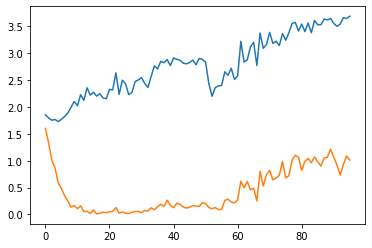

In [30]:
#loss function during training
plt.plot(cv_loss)
plt.plot(tr_loss)

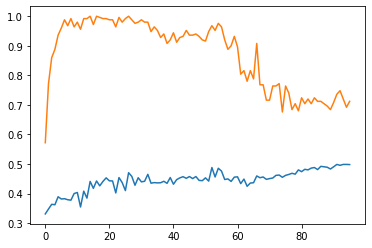

In [31]:
#accuracy during training
plt.plot(cv_acc)
plt.plot(tr_acc)